
#Introduction  
This project is a study of model performance comparison. It will clean and perform exploratory data analysis on BBC News data, followed by Natural Language Processing. The final corpora will be the target for the application of two machine learning techniques called matrix factorization and kmeans. The final goal of is to compare the two models, each representing unsupervised and supervised machine learning, respectively, and assess the difference.

##Exploratory Data Analysis (EDA)

In [ ]:
#import necessary modules and packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import re
import nltk
import string
import seaborn as sns
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

try:
  import pyvis
  from pyvis.network import Network
except:
  !pip install pyvis
  import pyvis
  from pyvis import Network
nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#Load data
path = 'drive/MyDrive/'
train = pd.read_csv(path + 'BBC News Train.csv')
test = pd.read_csv(path + 'BBC News Test.csv')
sol = pd.read_csv(path + 'BBC News Sample Solution.csv')

In [ ]:
#Examine overall data structure and contents
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [ ]:
train.head(10)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [ ]:
train.describe()

,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


In [ ]:
sol.head(5)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


Both the train and test datasets appear to be clean. The top 5 entries of the sample solution shows the structure we are aiming to achieve by the end of the study.  
  
Next, we'll look at histograms of categories to get a sense of the distribution.

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
dtype: int64


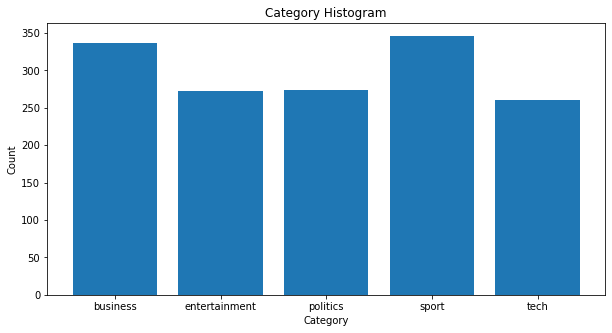

In [ ]:
count_occurrences = train.groupby(['Category']).size()
print(count_occurrences)

#Barplot of category frequency
x = list(count_occurrences.index)
y = [i for i in count_occurrences]

fig = plt.figure(figsize = (10, 5))
plt.bar(x, y)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Category Histogram")
plt.show()

Each category is roughly evenly distributed, with 'business' and 'sport' being the top two most common categories.

##Text Preprocessing
Implement helper functions to:
1. Lemmatize
2. Tokenize
3. Remove punctuation and stopwords

In [ ]:
#Define functions for Lemmatize, remove stopwords, punctuation, and tokenize.
w_tok = nltk.tokenize.word_tokenize
STEM = nltk.PorterStemmer()
LEMM = nltk.WordNetLemmatizer()

def tokenize(text, lowercase=True):
    if lowercase:
        text = text.lower()
        return w_tok(text)

def stem(tokens):
    return [STEM.stem(token) for token in tokens]

def lemmatize(tokens):
    lemm = []
    for token in tokens:
        if isinstance(token, str):
            lemm.append(LEMM.lemmatize(token)) # treats token like a noun
        else: # assume a tuple of (word, pos)
            lemm.append(LEMM.lemmatize(*token))
    return lemm

def remove_stopwords(tokens, stopwords = None):
    if stopwords is None:
        stopwords = nltk.corpus.stopwords.words("english")
    return [token for token in tokens if token not in stopwords]

def remove_punctuation(tokens):
    return [token for token in tokens if token not in string.punctuation]

In [ ]:
text_train = []
for i, t in enumerate(train['Text']):
    text = t
    prep_text = tokenize(text)
    prep_text = remove_stopwords(prep_text)
    prep_text = remove_punctuation(prep_text)
    prep_text = lemmatize(prep_text)
    text_train.append(' '.join(prep_text))

In [ ]:
train['Prep_Text'] = text_train

In [ ]:
print(train.head(5))

   ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

                                           Prep_Text  
0  worldcom ex-boss launch defence lawyer defendi...  
1  german business confidence slide german busine...  
2  bbc poll indicates economic gloom citizen majo...  
3  lifestyle governs mobile choice faster better ...  
4  enron boss 168m payout eighteen former enron d...  


In [ ]:
word_count = []
for i, j in enumerate(text_train):
    word_count.append(len(j.split()))
train['Word_Count'] = word_count

The preprocessing results show cleaned texts. Once again, we'll take a brief look at the histograms of the words per category.

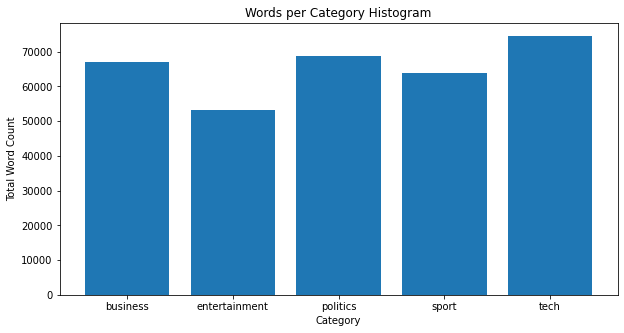

In [ ]:
wordlen_by_cat = (train.groupby(['Category']).sum())['Word_Count']
x = list(wordlen_by_cat.index)
y = [i for i in wordlen_by_cat]
fig = plt.figure(figsize = (10, 5))
plt.bar(x, y)
plt.xlabel("Category")
plt.ylabel("Total Word Count")
plt.title("Words per Category Histogram")
plt.show()

Total number of words per category also seems pretty uniform. The data preparation is complete and ready for model training.

In [ ]:
def label_permute_compare(ytdf, yh, n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
# your code here
    labels = ['business', 'tech', 'politics', 'sport', 'entertainment']
    str_perms = list(itertools.permutations(labels, n)) #permutations
    str_perms = np.asarray(str_perms) 

    try_labels = [str_perms[:, x] for x in yh]
    try_labels = np.asarray(try_labels)[:, None]
    count = [np.count_nonzero((try_labels[:, :, x]) == ytdf) for x in range(len(str_perms))]
    acc_idx = count.index(max(count))
    acc = max(count) / len(ytdf)
    order = tuple([labels.index(x) for x in str_perms[acc_idx]])
    
    return order, acc

In [ ]:
#Initiate Vectorizer
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.95, norm = 'l2', stop_words = 'english')
tfidf_train = tfidf.fit_transform(train['Prep_Text'])

#Generate Model
mod = NMF(n_components = len(x), init = 'nndsvda', solver = 'mu', beta_loss = 'kullback-leibler', l1_ratio = 0.5, random_state = 1234)
mat = mod.fit_transform(tfidf_train)

In [ ]:
#Prediction output
yh_train = mat.argmax(axis = 1)

In [ ]:
labelorder, acc = label_permute_compare(train, yh_train)

The classification assigns labels randomly. The code below is to match the correct labels to each cluster, as well as create a confusion matrix for better visualization.

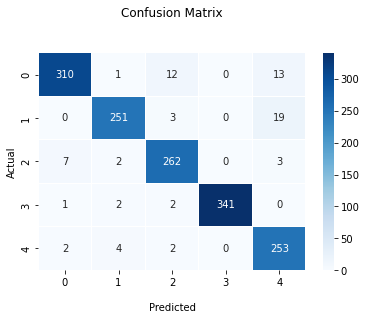

In [ ]:
#Create Confusion Matrix for better visualization
cluster_labels = {0: 'tech', 1: 'politics', 2: 'entertainment', 3: 'sport', 4: 'entertainment'}

label_num = [labels[i] for i in labelorder]
yh = [label_num[i] for i in yh_train]
conf_matrix = confusion_matrix(train['Category'], yh)
conf_matrix = sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'g', linewidths = 0.1)
conf_matrix.set_title('Confusion Matrix\n\n');
conf_matrix.set_xlabel('\nPredicted');
conf_matrix.set_ylabel('Actual');

In [ ]:
#Verify
print(label_num)
print(yh_train[:10])
print(train['Category'][:10])

['tech', 'politics', 'entertainment', 'sport', 'business']
[4 4 4 0 4 1 3 2 4 2]
0         business
1         business
2         business
3             tech
4         business
5         politics
6            sport
7    entertainment
8         business
9    entertainment
Name: Category, dtype: object


This verifies that we obtained the correct cluster labels. The predicted output integers represent the indices of the cluster labels. We can create a dictionary to better keep track of cluster numbers and the matching category names.

Now we will validate using the test data and see how the model performs.

In [ ]:
text_test = []
for i, t in enumerate(test['Text']):
    text = t
    prep_text = tokenize(text)
    prep_text = remove_stopwords(prep_text)
    prep_text = remove_punctuation(prep_text)
    prep_text = lemmatize(prep_text)
    text_test.append(' '.join(prep_text))

In [ ]:
test['Prep_Text'] = text_test

In [ ]:
print(test.head(5))

   ArticleId                                               Text  \
0       1018  qpr keeper day heads for preston queens park r...   
1       1319  software watching while you work software that...   
2       1138  d arcy injury adds to ireland woe gordon d arc...   
3        459  india s reliance family feud heats up the ongo...   
4       1020  boro suffer morrison injury blow middlesbrough...   

                                           Prep_Text  
0  qpr keeper day head preston queen park ranger ...  
1  software watching work software monitor every ...  
2  arcy injury add ireland woe gordon arcy ruled ...  
3  india reliance family feud heat ongoing public...  
4  boro suffer morrison injury blow middlesbrough...  


In [ ]:
tfidf_test = tfidf.transform(test['Prep_Text'])
mat_test = mod.transform(tfidf_test)

In [ ]:
yh_test = mat_test.argmax(axis = 1)
test['y_hat'] = yh_test
test_results = pd.DataFrame(columns = ['ArticleId', 'Category'])
test_results['ArticleId'] = test['ArticleId']
yh_cat = test['y_hat'].apply(lambda i: cluster_labels[i])
test_results['Category'] = yh_cat
print(test.tail(10))

     ArticleId                                               Text  \
725       2155  green reports shun supply chain nearly 20% mor...   
726        553  the memory driving brown s mission the memory ...   
727        551  labour accused of broken pledge labour has alr...   
728       1724  pc photo printers challenge pros home printed ...   
729       1512  dogged federer claims dubai crown world number...   
730       1923  eu to probe alitalia  state aid  the european ...   
731        373  u2 to play at grammy awards show irish rock ba...   
732       1704  sport betting rules in spotlight a group of mp...   
733        206  alfa romeos  to get gm engines  fiat is to sto...   
734        471  citizenship event for 18s touted citizenship c...   

                                             Prep_Text  y_hat  \
725  green report shun supply chain nearly 20 uk to...      4   
726  memory driving brown mission memory gordon bro...      1   
727  labour accused broken pledge labour alre

In [ ]:
valuemf = test_results.Category.isin(train.Category).astype(int)
count = 0
for i in range(len(test_results)):
    if test_results.Category[i] == train.Category[i]:
        count += 1

print(count/len(test_results))

0.16598639455782313


In [ ]:
test_results.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,entertainment
4,1020,sport


We have the test dataset and its articles classified to their predicted categories. 

#Part 2: Use the Movies data from Week 3
Now we will compare performance when Unsupervised ML technique is used on a more appropriate dataset, namely the movies and user ratings datset.

In [ ]:
#Load data
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
MV_users = pd.read_csv(path + 'users.csv')
MV_movies = pd.read_csv(path + 'movies.csv')

In [ ]:
from collections import namedtuple
Data = namedtuple('Data', ['users','movies','train','test'])
data = Data(MV_users, MV_movies, train, test)

In [ ]:
data.train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700146 entries, 0 to 700145
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   uID     700146 non-null  int64
 1   mID     700146 non-null  int64
 2   rating  700146 non-null  int64
dtypes: int64(3)
memory usage: 16.0 MB


In [ ]:
data.train.head()

,uID,mID,rating
0,744,1210,5
1,3040,1584,4
2,1451,1293,5
3,5455,3176,2
4,2507,3074,5


In [ ]:
data.movies.head()

,mID,title,year,Doc,Com,Hor,Adv,Wes,Dra,Ani,...,Chi,Cri,Thr,Sci,Mys,Rom,Fil,Fan,Act,Mus
0,1,Toy Story,1995,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,Grumpier Old Men,1995,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from scipy.sparse import coo_matrix, csr_matrix

In [ ]:
#Calculate Movie-Feature Matrix
genres_data = data.movies.drop((['mID', 'year', 'title']), 1, inplace = False)
genres_data = np.reshape(genres_data, (3883, 18))

#Calculate Rating-Matrix (in case for later use)
allusers = list(data.users['uID'])
allmovies = list(data.movies['mID'])
genres = list(data.movies.columns.drop(['mID', 'title', 'year']))
mid2idx = dict(zip(data.movies.mID,list(range(len(data.movies)))))
uid2idx = dict(zip(data.users.uID,list(range(len(data.users)))))

ind_movie = [mid2idx[x] for x in data.train.mID]
ind_user = [uid2idx[x] for x in data.train.uID]
rating_train = list(train.rating)
rating_matrix = np.array(coo_matrix((rating_train, (ind_user, ind_movie)), shape = (len(allusers), len(allmovies))).toarray())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
n_users = len(data.train.mID)
n_items = len(allmovies)

df = pd.DataFrame(rating_matrix, columns = allmovies)

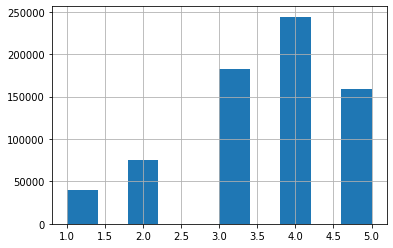

In [ ]:
#Observe overall distribution of ratings by looking at histogram.
train.rating.hist(grid = True)

In [ ]:
ratings_df = data.train
n_users = len(ratings_df['uID'].unique())
n_movies = len(ratings_df['mID'].unique())
R_shape = (n_users, n_movies)

X = ratings_df[['uID', 'mID']].values
y = ratings_df['rating'].values
print(X.shape)
print((y.shape))

(700146, 2)
(700146,)


In [ ]:
from scipy import sparse

def ToDense(X, y, shape):
    row = X[:, 0]
    col = X[:, 1]
    data = y
    matrix_sparse = sparse.csr_matrix((data, (row, col)), shape = (shape[0]+1, shape[0]+1))  # sparse matrix in compressed format (CSR)
    R = matrix_sparse.todense()   
    R = R[1:,1:]                  
    R = np.asarray(R)        
    return R

R = ToDense(X, y, R_shape)
print(R)
print(R.shape)

[[5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]]
(6040, 6040)


In [ ]:
print(len(R.nonzero()[0]) / float(R.shape[0] * R.shape[1]))

0.019191756940485066


Sparsity is about a proportion of 0.0192, or 1.92%.

Now we'll use NMF from scikit-learn to generate the models.

In [ ]:
mod = NMF(n_components = 18)
mod.fit(R)
theta = mod.transform(R)
latent_f = mod.components_.T

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [ ]:
Rhat = latent_f.dot(theta.T)
Rhat = Rhat.T

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [ ]:
Rtrain = ToDense(X_train, y_train, R_shape)
Rtest = ToDense(X_test, y_test, R_shape)

In [ ]:
print(Rtrain, Rtrain.shape)
print(Rtest, Rtest.shape)

[[5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (6040, 6040)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]] (6040, 6040)


Moving on to a familiar process where we define parameters to generate NMF model.

In [ ]:
est = NMF(n_components = 18, init = 'nndsvda', solver = 'mu', beta_loss = 'kullback-leibler', l1_ratio = 0.5, random_state = 1234)

In [ ]:
from sklearn.metrics import mean_squared_error

def RMSE(p, t):
   p = p[t.nonzero()].flatten()
   t = t[t.nonzero()].flatten()
   return np.sqrt(mean_squared_error(p, t))